In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import xml.etree.ElementTree as et
import os
pd.set_option("display.max_columns", None)

In [2]:
train_df = pd.read_csv('train.csv')
xtree = et.parse('holidays.xml')
weather_df = pd.read_csv('weather-sfcsv.csv')
weather_condition = weather_df['Weather_Condition'].unique()
weather_condition_dict = dict(zip(weather_condition, range(len(weather_condition))))
weather_df.replace({'Weather_Condition': weather_condition}, inplace=True)

In [3]:
def extract_date(df, column_name, date_format):
    df[column_name] = pd.to_datetime(df[column_name], format=date_format)
    df['Year'] = pd.DatetimeIndex(df[column_name]).year
    df['Month'] = pd.DatetimeIndex(df[column_name]).month
    df['Day'] = pd.DatetimeIndex(df[column_name]).day
    if len(date_format) > 8:
        df['Hour'] = pd.DatetimeIndex(df[column_name]).hour
    df.drop([column_name], axis= 1, inplace=True)
    
def normalize_data(df, *args):
    for arg in args:
        df[arg] = (df[arg] - df[arg].mean())/df[arg].std()
        
def merge_data(data):
    extract_date(data, 'timestamp', '%Y-%m-%d %H:%M:%S')
    data = data.drop_duplicates(subset=data.keys(), keep='last')
    df = pd.merge(data, weather_df_wd,  how='left', left_on=['Year', 'Day', 'Month', 'Hour'], right_on = ['Year', 'Day', 'Month', 'Hour'])
    df.dropna(axis=0, subset=['Weather_Condition', 'Temperature(F)', 'Humidity(%)', 'Visibility(mi)'], inplace=True)
    df.fillna(value=df.mean(), inplace=True)
    df.replace({True: 1, False: 0, 'Yes': 1, 'No': 0, 'R': 1, 'L': 0}, inplace=True)
    df['Weather_Condition'].replace(df['Weather_Condition'].unique(),range(len(df['Weather_Condition'].unique())), inplace=True)
    normalize_data(df, 'Lat', 'Lng', 'Wind_Speed(mph)', 'Wind_Chill(F)', 'Temperature(F)', 'Visibility(mi)', 'Year')
    df['Humidity'] = df['Humidity(%)'] / 100
    df = pd.merge(df, holiday_df,  how='left', left_on=['Year', 'Day', 'Month'], right_on = ['Year', 'Day', 'Month'])
    df.fillna(0, inplace=True)
    return df

In [4]:
xroot = xtree.getroot()
df_cols = ['date', 'description']
rows = []
for node in xroot:
    s_name = node.find("date").text if node is not None else None
    s_mail = node.find("description").text if node is not None else None
    rows.append({"date": s_name, "description": s_mail})
holiday_df = pd.DataFrame(rows, columns = df_cols)
extract_date(holiday_df, 'date', '%Y-%m-%d')
holiday_df["description"] = 1
weather_df_wd = weather_df.drop_duplicates(subset=['Year', 'Day', 'Month', 'Hour'], keep='last')

In [5]:
print("Training Data info:")
print(train_df.info())
print(train_df.head())
print("\nWeather Data info:")
print(weather_df.info())
print(weather_df.head())
print("\nHoliday Data info:")
print(holiday_df.info())
print(holiday_df.head())

Training Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6407 entries, 0 to 6406
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            6407 non-null   int64  
 1   Lat           6407 non-null   float64
 2   Lng           6407 non-null   float64
 3   Bump          6407 non-null   bool   
 4   Distance(mi)  6407 non-null   float64
 5   Crossing      6407 non-null   bool   
 6   Give_Way      6407 non-null   bool   
 7   Junction      6407 non-null   bool   
 8   No_Exit       6407 non-null   bool   
 9   Railway       6407 non-null   bool   
 10  Roundabout    6407 non-null   bool   
 11  Stop          6407 non-null   bool   
 12  Amenity       6407 non-null   bool   
 13  Side          6407 non-null   object 
 14  Severity      6407 non-null   int64  
 15  timestamp     6407 non-null   object 
dtypes: bool(9), float64(3), int64(2), object(2)
memory usage: 406.8+ KB
None
   ID        Lat     

In [6]:
df = merge_data(train_df)

<ipython-input-3-f949fa4cbf69>:17: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(value=df.mean(), inplace=True)
/Users/mohamedgamal/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1200: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


In [7]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
columns_removed = ['ID', 'Roundabout', 'Bump', 'Humidity(%)',
                   'No_Exit', 'Wind_Speed(mph)', 'Temperature(F)',
                   'Visibility(mi)', 'Day', 'Severity']
X_train = train_df.drop(columns=columns_removed)
y_train = train_df['Severity']

X_val = val_df.drop(columns=columns_removed)
y_val = val_df['Severity']

<AxesSubplot:title={'center':'Data Correlation'}>

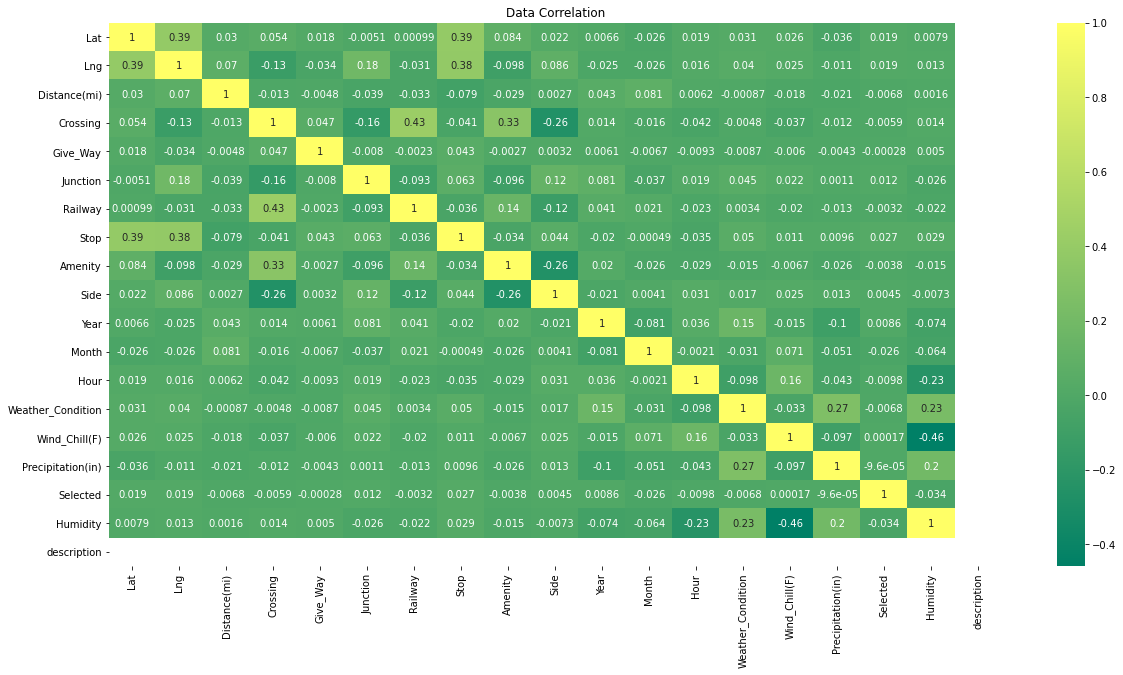

In [8]:
plt.figure(figsize=(20,10))
plt.title('Data Correlation')
sns.heatmap(X_train.corr(),annot= True,cmap='summer')

In [9]:
from sklearn.ensemble import RandomForestClassifier

# Create an instance of the classifier
classifier = RandomForestClassifier(max_depth=2, random_state=0)

# Train the classifier
classifier = classifier.fit(X_train, y_train)

In [10]:
print("The accuracy of the classifier on the validation set is ", (classifier.score(X_val, y_val)))

The accuracy of the classifier on the validation set is  0.765807962529274


In [11]:
test_df = pd.read_csv('test.csv')

X_test = merge_data(test_df)

# You should update/remove the next line once you change the features used for training
columns_removed = ['ID', 'Roundabout', 'Bump', 'Humidity(%)',
                   'No_Exit', 'Wind_Speed(mph)', 'Temperature(F)',
                   'Visibility(mi)', 'Day']
X_test = X_test.drop(columns=columns_removed)

y_test_predicted = classifier.predict(X_test)

test_df['Severity'] = y_test_predicted

test_df.head()

<ipython-input-3-f949fa4cbf69>:17: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(value=df.mean(), inplace=True)
/Users/mohamedgamal/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1200: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


,ID,Lat,Lng,Bump,Distance(mi),Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Stop,Amenity,Side,Year,Month,Day,Hour,Severity
0,6407,37.786060,-122.390900,False,0.039,False,False,True,False,False,False,False,False,R,2016,4,4,19,2
1,6408,37.769609,-122.415057,False,0.202,False,False,False,False,False,False,False,False,R,2020,10,28,11,2
2,6409,37.807495,-122.476021,False,0.000,False,False,False,False,False,False,False,False,R,2019,9,9,7,2
3,6410,37.761818,-122.405869,False,0.000,False,False,True,False,False,False,False,False,R,2019,8,6,15,2
4,6411,37.732350,-122.414100,False,0.670,False,False,False,False,False,False,False,False,R,2018,10,17,9,2


In [12]:
test_df[['ID', 'Severity']].to_csv('submission.csv', index=False)